In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('.'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
            matrix_dims = (256,256,128),
            baseline = (1500, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
wire = tissue.Tissue(name='wire', c=1600, rho=1100, sigma=30, scale=0.0001, label=1)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

test_phantom.add_tissue_sphere((0,0,0), 8, wire)
test_phantom.add_tissue_sphere((pos,0,0), 16, wire)
test_phantom.add_tissue_sphere((0,pos,0), 8, wire)
test_phantom.add_tissue_sphere((pos,pos,0), 4, wire)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

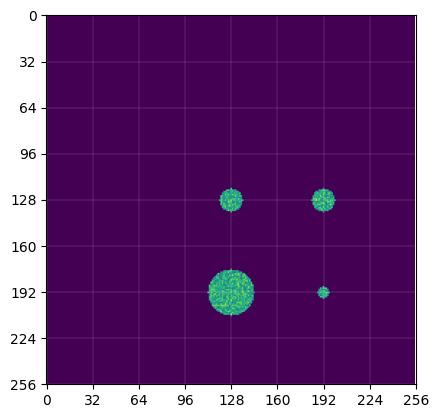

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [4]:
num_transducers = 2
transducers = [transducer.Planewave(max_frequency=2e6,
                                    elements = 128, 
                                    width = 36e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5,
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

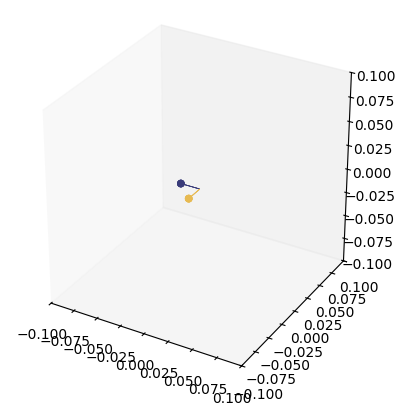

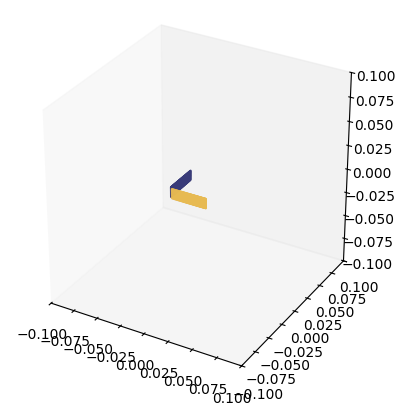

In [5]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.02,0,0]))
cont_transducer_set.assign_pose(1, geometry.Transform([np.pi/2,0,0], [0,-0.02,0]))


cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

In [6]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (50e-3,50e-3,20e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'extended_aperture_spheres',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'tar_aperture_spheres',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

extended_experiment.save()
tar_experiment.save()

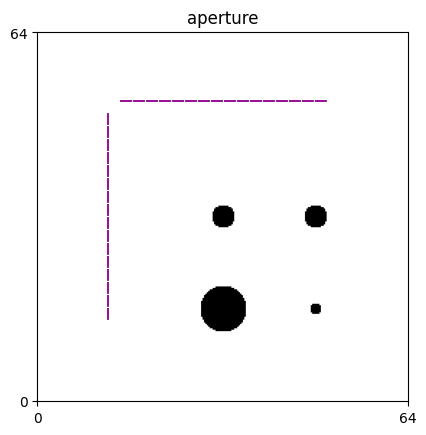

In [9]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2+1])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,256])
plt.gca().set_xticklabels(['0','64'])
plt.gca().set_yticks([0,256])
plt.gca().set_yticklabels(['64','0'])
plt.savefig('spheres_phantom.png', dpi=300, bbox_inches="tight")

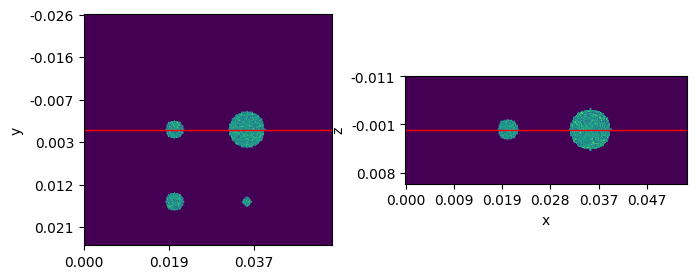

In [10]:
extended_experiment.plot_ray_path(0)

In [11]:
test_experiment = experiment.Experiment.load('tar_aperture_spheres')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

Number of simulation results (0) is less than the expected number of simulation results (10), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

running with 2 workers



preparation for sim    0 completed in 11.65 seconds
preparation for sim    1 completed in 12.91 seconds
simulation             0 completed in 21.93 seconds
preparation for sim    2 completed in 12.26 seconds
simulation             1 completed in 25.61 seconds
preparation for sim    3 completed in 13.52 seconds
simulation             2 completed in 31.33 seconds
preparation for sim    4 completed in 16.73 seconds
simulation             3 completed in 37.56 seconds
preparation for sim    5 completed in 11.65 seconds
simulation             4 completed in 31.30 seconds
preparation for sim    6 completed in 11.56 seconds
simulation             5 completed in 30.84 seconds
preparation for sim    7 completed in 12.71 seconds
simulation             6 completed in 34.97 seconds
preparation for sim    8 completed in 11.48 seconds
simulation             7 completed in 34.31 seconds
preparation for sim    9 completed in 13.14 seconds
simulation             8 completed in 36.36 seconds
simulation  

In [12]:
test_experiment = experiment.Experiment.load('extended_aperture_spheres')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

Number of simulation results (0) is less than the expected number of simulation results (10), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

running with 2 workers



preparation for sim    0 completed in 12.24 seconds
preparation for sim    1 completed in 11.90 seconds
simulation             0 completed in 32.88 seconds
preparation for sim    2 completed in 11.39 seconds
simulation             1 completed in 30.77 seconds
preparation for sim    3 completed in 14.46 seconds
simulation             2 completed in 37.08 seconds
preparation for sim    4 completed in 15.79 seconds
simulation             3 completed in 38.87 seconds
preparation for sim    5 completed in 13.28 seconds
simulation             4 completed in 41.48 seconds
preparation for sim    6 completed in 13.29 seconds
simulation             5 completed in 41.16 seconds
preparation for sim    7 completed in 12.19 seconds
simulation             6 completed in 35.33 seconds
preparation for sim    8 completed in 12.08 seconds
simulation             7 completed in 34.87 seconds
preparation for sim    9 completed in 15.31 seconds
simulation             8 completed in 44.67 seconds
simulation  

# Reconstruction

In [13]:
test_experiment = experiment.Experiment.load('tar_aperture_spheres')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


In [14]:
images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 10/10 [00:00<00:00, 251155.93it/s]


In [15]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//2], axis=0)/len(images1)//2
image1t2 = np.sum(images1[len(images1)//2:], axis=0)/len(images1)//2
image1_mult = np.multiply(image1t1, image1t2)

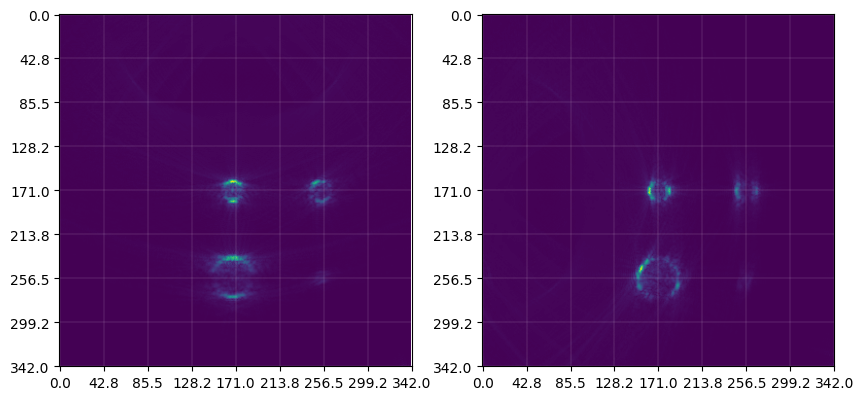

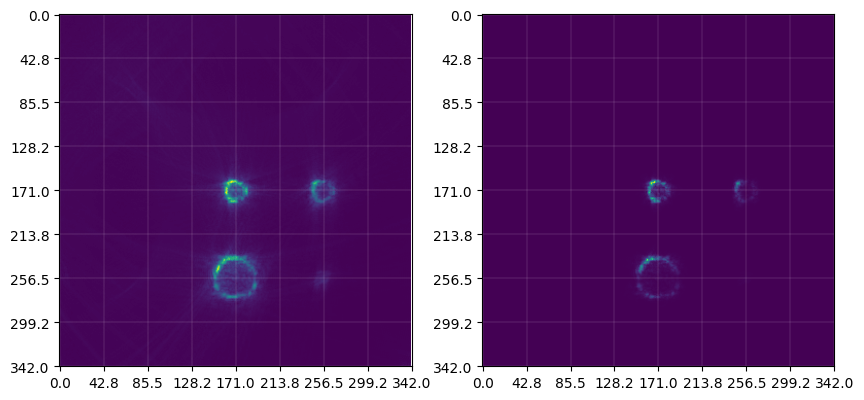

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image1t1)
ax[1].imshow(image1t2)
for a in ax:
    a.set_xticks(np.linspace(0, image1.shape[1],9))
    a.set_yticks(np.linspace(0, image1.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image1[:,:,image1.shape[2]//2])
ax[1].imshow(image1_mult[:,:,image1_mult.shape[2]//2])
for a in ax:
    a.set_xticks(np.linspace(0, image1.shape[1],9))
    a.set_yticks(np.linspace(0, image1.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)

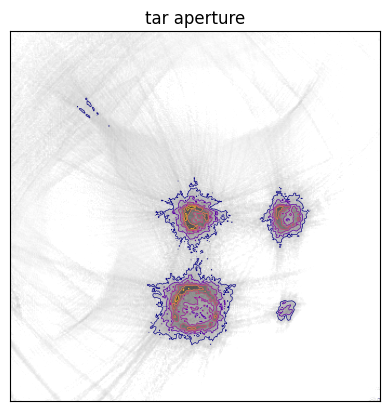

In [34]:
psf = 20 * np.log10(image1 / 1000000) # source_strength set to 1e6
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
# ax.clabel(CS, inline=True, fontsize=5)
ax.set_title('tar aperture')
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar(im)
plt.savefig('spheres_tar_aperture.png', dpi=300, bbox_inches="tight")

In [18]:
# psf = 20 * np.log10(image1_mult / 1000000 ** 2)
# image = psf[:,:,psf.shape[2]//2]

# fig, ax = plt.subplots()

# ax.imshow(image, cmap='gray_r', vmin=-25, vmax=0)
# gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
# x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
# y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
# X, Y = np.meshgrid(x, y)
# CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-25,-20,-15,-10,-5,0,])
# # ax.clabel(CS, inline=True, fontsize=10)
# ax.set_title('tar aperture multiplicative')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('x_tar_aperture_mult.png', dpi=300)

In [19]:
test_experiment = experiment.Experiment.load('extended_aperture_spheres')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


In [20]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 10/10 [00:00<00:00, 274137.52it/s]


In [21]:
image2 = np.sum(images2, axis=0)
image2t1 = np.sum(images2[:len(images2)//2], axis=0)
image2t2 = np.sum(images2[len(images2)//2:], axis=0)
image2_mult = np.multiply(image2t1, image2t2)

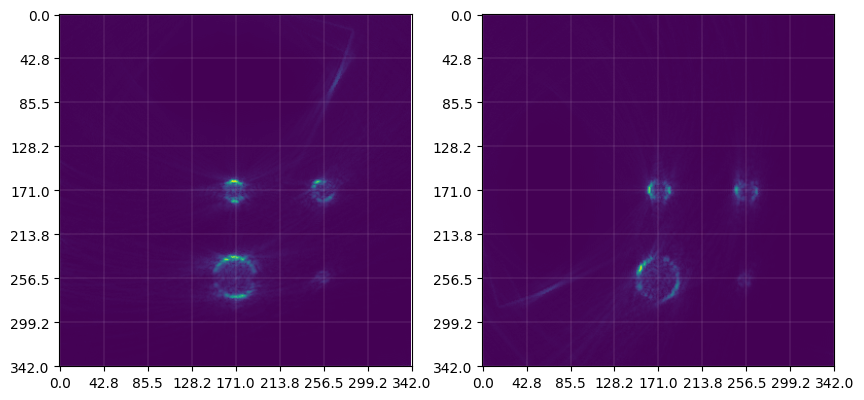

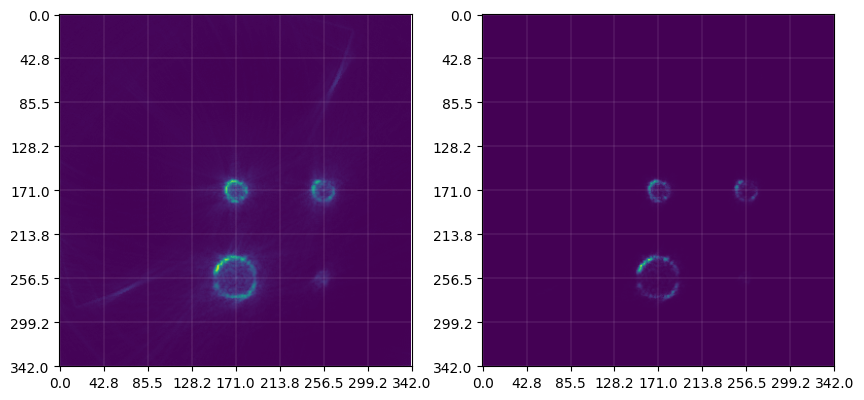

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image2t1)
ax[1].imshow(image2t2)
for a in ax:
    a.set_xticks(np.linspace(0, image2.shape[1],9))
    a.set_yticks(np.linspace(0, image2.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image2[:,:,image2.shape[2]//2])
ax[1].imshow(image2_mult[:,:,image2_mult.shape[2]//2])
for a in ax:
    a.set_xticks(np.linspace(0, image2.shape[1],9))
    a.set_yticks(np.linspace(0, image2.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)

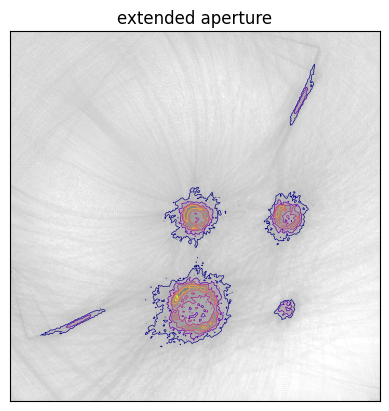

In [40]:
psf = 20 * np.log10(image2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=-0)
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-75,-70,-65,-60,-55,-50])
# ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture')
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar(im)
plt.savefig('sphere_extended_aperture.png', dpi=300, bbox_inches="tight")